In [24]:
from matplotlib import pyplot as plt
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST

In [25]:
os.chdir('/Users/rraj/PythonFunctions/DCNet/')
os.getcwd()

'/Users/rraj/PythonFunctions/DCNet'

In [26]:
LATENT_DIM = 2
NEPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 0.001

DC_OUT_DIM = 1000
DC_NEPOCHS = 5
DC_NBATCHES = 20

In [27]:
mnist_data = MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

mnist_test_data = MNIST(
    root = 'data',
    train = False,                         
    transform = transforms.ToTensor(), 
    download = True,            
)

In [28]:
N = len(mnist_data)
train_data, val_data = random_split(mnist_data, [int(0.8*N), int(0.2*N)])

train_loader = DataLoader(mnist_data, batch_size=BATCH_SIZE, shuffle=True)
#val_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_test_data, batch_size=BATCH_SIZE)

In [6]:
class Encoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        self.relu3 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3*3*32, 128)
        self.relu4 = nn.ReLU()
        self.linear2 = nn.Linear(128, latent_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.conv1(x)
        x_ = self.relu1(x_)
        x_ = self.conv2(x_)
        x_ = self.relu2(x_)
        x_ = self.conv3(x_)
        x_ = self.relu3(x_)
        x_ = self.flatten(x_)
        x_ = self.linear1(x_)
        x_ = self.relu4(x_)
        x_f = self.linear2(x_)
        return x_f
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 3*3*32)
        self.relu2 = nn.ReLU()
        self.reshape = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        self.conv1 = nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0)
        self.norm1 = nn.BatchNorm2d(16)
        self.relu3 = nn.ReLU()
        self.conv2 = nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1)
        self.norm2 = nn.BatchNorm2d(8)
        self.relu4 = nn.ReLU()
        self.conv3 = nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.linear1(x)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_ = self.relu2(x_)
        x_ = self.reshape(x_)
        x_ = self.conv1(x_)
        x_ = self.norm1(x_)
        x_ = self.relu3(x_)
        x_ = self.conv2(x_)
        x_ = self.norm2(x_)
        x_ = self.relu4(x_)
        x_ = self.conv3(x_)
        x_f = self.sigmoid(x_)
        return x_f
        
        

In [7]:
encoder = Encoder(LATENT_DIM)
decoder = Decoder(LATENT_DIM)

parameters_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(parameters_to_optimize, lr=LEARNING_RATE, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder.to(device)
decoder.to(device)

print(device)

cpu


In [8]:
encoder.train()
decoder.train()

for epoch in range(NEPOCHS):
    running_loss = 0
    for data, _ in tqdm(train_loader, total=len(train_loader), desc=f"Epoch:{epoch+1}/{NEPOCHS}"):
        data.to(device)
            
        optimizer.zero_grad()
            
        encoder_output = encoder(data)
        decoder_output = decoder(encoder_output)
        loss = loss_fn(data, decoder_output)
            
        loss.backward()
        optimizer.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")

Epoch:1/10:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch:1/10: 100%|██████████| 188/188 [00:18<00:00,  9.93it/s]


running_loss=0.084


Epoch:2/10: 100%|██████████| 188/188 [00:18<00:00, 10.27it/s]


running_loss=0.056


Epoch:3/10: 100%|██████████| 188/188 [00:18<00:00, 10.25it/s]


running_loss=0.051


Epoch:4/10: 100%|██████████| 188/188 [00:18<00:00, 10.38it/s]


running_loss=0.048


Epoch:5/10: 100%|██████████| 188/188 [00:18<00:00, 10.37it/s]


running_loss=0.047


Epoch:6/10: 100%|██████████| 188/188 [00:18<00:00, 10.31it/s]


running_loss=0.047


Epoch:7/10: 100%|██████████| 188/188 [00:18<00:00, 10.27it/s]


running_loss=0.047


Epoch:8/10: 100%|██████████| 188/188 [00:19<00:00,  9.41it/s]


running_loss=0.045


Epoch:9/10: 100%|██████████| 188/188 [00:20<00:00,  9.11it/s]


running_loss=0.046


Epoch:10/10: 100%|██████████| 188/188 [00:21<00:00,  8.83it/s]

running_loss=0.045


In [9]:
encoder.eval()
decoder.eval()

inputs, targets, latents, reconstructions = [], [], [], []

with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
        inputs.append(data)
        targets.append(target)
        
        data.to(device)
        
        encoder_output = encoder(data)
        decoder_output = decoder(encoder_output)
        
        latents.append(encoder_output.cpu())
        reconstructions.append(decoder_output.cpu())

100%|██████████| 40/40 [00:01<00:00, 22.63it/s]


In [10]:
def plot_reconstructions(nimages: int) -> None:
    fig, ax = plt.subplots(2, nimages, figsize=(6*nimages,10))
    n = torch.randint(0, len(inputs), (1,)).item()
    for i in range(nimages):
        img = inputs[n][i].numpy().transpose((1, 2, 0))
        ax[0,i].imshow(img)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        rec = reconstructions[n][i].numpy().transpose((1, 2, 0))
        ax[1,i].imshow(rec)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])

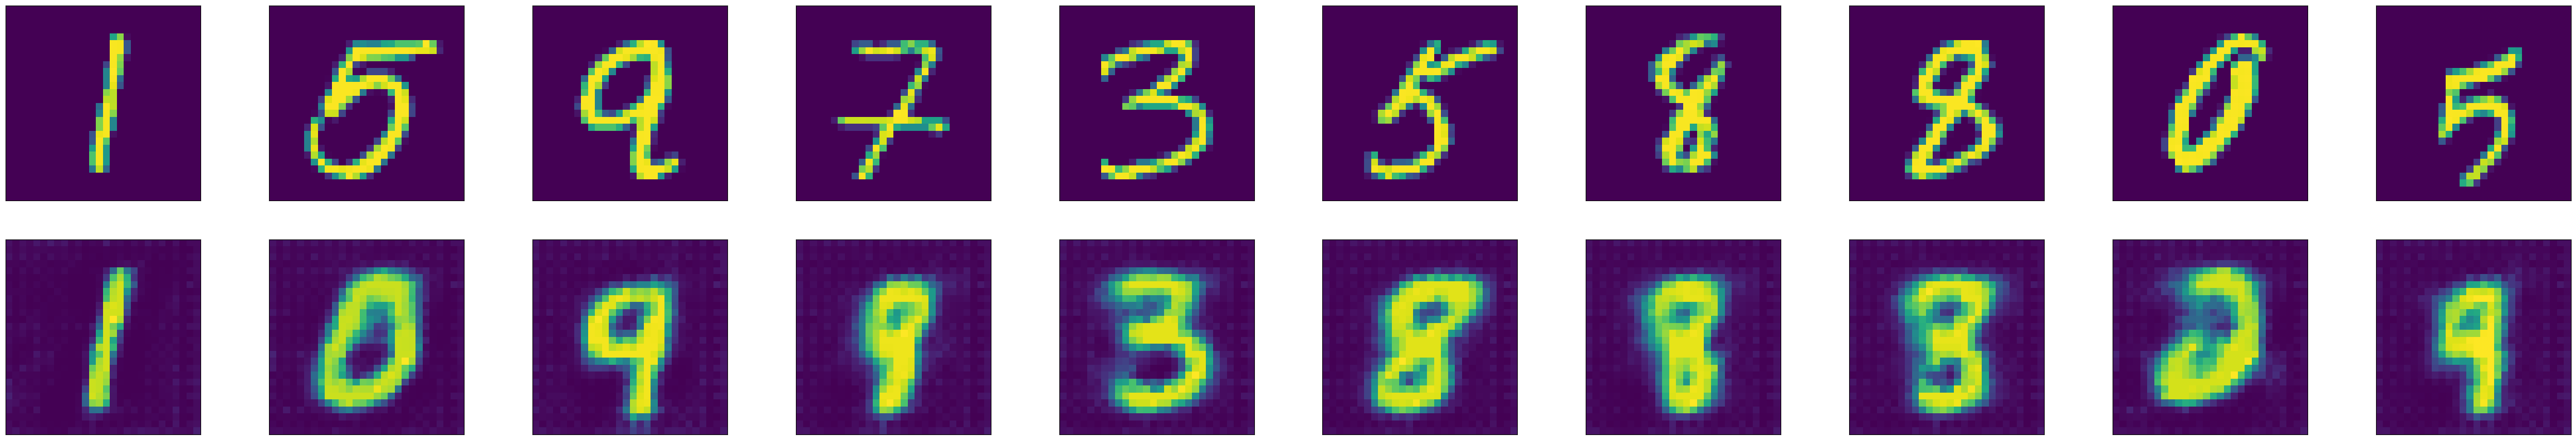

In [11]:
plot_reconstructions(10)

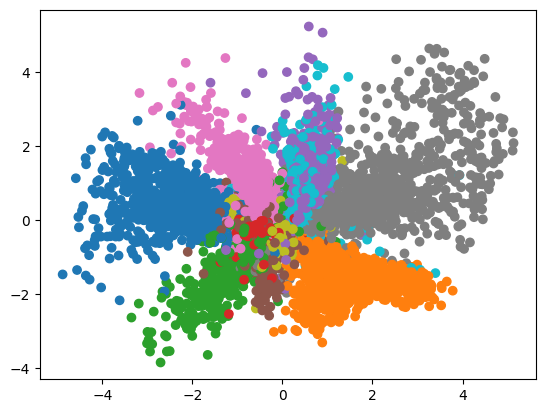

In [12]:
from sklearn.decomposition import PCA

latents_combined = torch.empty(0)
targets_combined = torch.empty(0)
for latent, target in zip(latents, targets):
    latents_combined = torch.cat((latents_combined, latent), dim=0)
    targets_combined = torch.cat((targets_combined, target), dim=0)
    
projections = PCA(n_components=2).fit_transform(latents_combined)
plt.scatter(projections[:,0], projections[:,1], c=targets_combined, cmap='tab10')

In [13]:
from layers import DiscriminationModule
from initialization import DatasetInitializer
import transformations
from loading import SequentialLoader

dc_transform = transformations.Compose([transformations.Scale(), transformations.ToVector()])

disc_layer = DiscriminationModule(DC_OUT_DIM, initializer=DatasetInitializer(mnist_data, transforms=dc_transform), beta=0.98)
loader = SequentialLoader(mnist_data, transforms=dc_transform)

for epoch in range(DC_NEPOCHS):
    for batches in tqdm(range(DC_NBATCHES), desc=f"Epoch:{epoch+1}/{DC_NEPOCHS}"):
        for x in loader(BATCH_SIZE):
            x = disc_layer(x)
        disc_layer.organize()

Epoch:5/5: 100%|██████████| 20/20 [1:36:49<00:00, 290.47s/it]


In [14]:
from plotting import MatrixPlotter
plotter = MatrixPlotter(DC_OUT_DIM, layout='auto')
plotter(disc_layer.connections.T)

In [15]:
def batch_DCNet(data: torch.Tensor, transform: transformations):
    outputs = torch.empty(0)
    with torch.no_grad():
        for x in data:
            x = transform(x)
            out = disc_layer(x, train=False)
            outputs = torch.cat((outputs, out.detach().cpu()), dim=0)
    return outputs

In [16]:
INPUT_EMBEDDINGS = []
INPUT_TARGETS = []

for data, target in tqdm(train_loader, total=len(train_loader)):
    embeddings_dc = batch_DCNet(data, transform=dc_transform)
    INPUT_EMBEDDINGS.append(embeddings_dc)
    INPUT_TARGETS.append(target)

EMBEDDINGS = torch.empty(0)
TARGETS = torch.empty(0)

for embedding, target in zip(INPUT_EMBEDDINGS, INPUT_TARGETS):
    EMBEDDINGS = torch.cat((EMBEDDINGS, embedding), dim=0)
    TARGETS = torch.cat((TARGETS, target), dim=0)

100%|██████████| 188/188 [14:50:55<00:00, 284.34s/it]  


In [17]:
class EmbeddingsDCNet(Dataset):
    def __init__(self) -> None:
        super().__init__()
        
    def __len__(self):
        return len(EMBEDDINGS)
    
    def __getitem__(self, index):
        return EMBEDDINGS[index], TARGETS[index]

In [18]:
class EncoderDCNet(nn.Module):
    def __init__(self, out_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(out_dim, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(32, latent_dim)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.linear1(x)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_ = self.relu2(x_)
        x_ = self.linear3(x_)
        x_ = self.relu3(x_)
        x_f = self.linear4(x_)
        return x_f

class DecoderDCNet(nn.Module):
    def __init__(self, out_dim: int, latent_dim: int) -> None:
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, 32)
        self.norm1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 64)
        self.norm2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 128)
        self.norm3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(128, out_dim)
        self.relu4 = nn.ReLU()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_ = self.linear1(x)
        x_ = self.norm1(x_)
        x_ = self.relu1(x_)
        x_ = self.linear2(x_)
        x_ = self.norm2(x_)
        x_ = self.relu2(x_)
        x_ = self.linear3(x_)
        x_ = self.norm3(x_)
        x_ = self.relu3(x_)
        x_ = self.linear4(x_)
        x_f = self.relu4(x_)
        return x_f        

In [19]:
encoder_dc = EncoderDCNet(DC_OUT_DIM, LATENT_DIM)
decoder_dc = DecoderDCNet(DC_OUT_DIM, LATENT_DIM)

parameters_to_optimize_dc = [
    {'params': encoder_dc.parameters()},
    {'params': decoder_dc.parameters()}
]

loss_fn = nn.MSELoss()
optimizer_dc = torch.optim.Adam(parameters_to_optimize_dc, lr=LEARNING_RATE, weight_decay=1e-5)

embedding_loader = DataLoader(EmbeddingsDCNet(), batch_size=10*BATCH_SIZE, shuffle=True)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
encoder_dc.to(device)
decoder_dc.to(device)

print(device)

cpu


In [20]:
encoder_dc.train()
decoder_dc.train()

for epoch in range(10*NEPOCHS):
    running_loss = 0
    for data, _ in tqdm(embedding_loader, total=len(embedding_loader), desc=f"Epoch:{epoch+1}/{10*NEPOCHS}"):

        data.to(device)
            
        optimizer_dc.zero_grad()
            
        encoder_output = encoder_dc(data)
        decoder_output = decoder_dc(encoder_output)
        loss = loss_fn(data, decoder_output)
            
        loss.backward()
        optimizer_dc.step()
        
        running_loss = loss.item()
    print(f"{running_loss=:.3f}")

Epoch:1/100: 100%|██████████| 19/19 [00:02<00:00,  8.78it/s]


running_loss=0.107


Epoch:2/100: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


running_loss=0.106


Epoch:3/100: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


running_loss=0.100


Epoch:4/100: 100%|██████████| 19/19 [00:04<00:00,  4.28it/s]


running_loss=0.100


Epoch:5/100: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]


running_loss=0.096


Epoch:6/100: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


running_loss=0.095


Epoch:7/100: 100%|██████████| 19/19 [00:01<00:00, 10.47it/s]


running_loss=0.092


Epoch:8/100: 100%|██████████| 19/19 [00:01<00:00, 11.25it/s]


running_loss=0.091


Epoch:9/100: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


running_loss=0.088


Epoch:10/100: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


running_loss=0.088


Epoch:11/100: 100%|██████████| 19/19 [00:02<00:00,  6.93it/s]


running_loss=0.086


Epoch:12/100: 100%|██████████| 19/19 [00:01<00:00, 10.86it/s]


running_loss=0.089


Epoch:13/100: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


running_loss=0.087


Epoch:14/100: 100%|██████████| 19/19 [00:01<00:00, 10.76it/s]


running_loss=0.084


Epoch:15/100: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


running_loss=0.084


Epoch:16/100: 100%|██████████| 19/19 [00:01<00:00, 10.65it/s]


running_loss=0.081


Epoch:17/100: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


running_loss=0.084


Epoch:18/100: 100%|██████████| 19/19 [00:01<00:00, 11.26it/s]


running_loss=0.082


Epoch:19/100: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


running_loss=0.082


Epoch:20/100: 100%|██████████| 19/19 [00:02<00:00,  6.83it/s]


running_loss=0.082


Epoch:21/100: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


running_loss=0.081


Epoch:22/100: 100%|██████████| 19/19 [00:01<00:00, 10.88it/s]


running_loss=0.080


Epoch:23/100: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


running_loss=0.083


Epoch:24/100: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


running_loss=0.081


Epoch:25/100: 100%|██████████| 19/19 [00:01<00:00, 11.28it/s]


running_loss=0.080


Epoch:26/100: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


running_loss=0.078


Epoch:27/100: 100%|██████████| 19/19 [00:01<00:00, 11.09it/s]


running_loss=0.078


Epoch:28/100: 100%|██████████| 19/19 [00:02<00:00,  6.92it/s]


running_loss=0.080


Epoch:29/100: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]


running_loss=0.080


Epoch:30/100: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


running_loss=0.080


Epoch:31/100: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


running_loss=0.079


Epoch:32/100: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


running_loss=0.076


Epoch:33/100: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


running_loss=0.076


Epoch:34/100: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


running_loss=0.076


Epoch:35/100: 100%|██████████| 19/19 [00:01<00:00, 11.06it/s]


running_loss=0.078


Epoch:36/100: 100%|██████████| 19/19 [00:02<00:00,  6.84it/s]


running_loss=0.077


Epoch:37/100: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


running_loss=0.075


Epoch:38/100: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


running_loss=0.076


Epoch:39/100: 100%|██████████| 19/19 [00:01<00:00, 11.10it/s]


running_loss=0.074


Epoch:40/100: 100%|██████████| 19/19 [00:01<00:00, 10.95it/s]


running_loss=0.074


Epoch:41/100: 100%|██████████| 19/19 [00:01<00:00, 11.11it/s]


running_loss=0.076


Epoch:42/100: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


running_loss=0.077


Epoch:43/100: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


running_loss=0.075


Epoch:44/100: 100%|██████████| 19/19 [00:02<00:00,  6.80it/s]


running_loss=0.075


Epoch:45/100: 100%|██████████| 19/19 [00:01<00:00, 10.72it/s]


running_loss=0.075


Epoch:46/100: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


running_loss=0.073


Epoch:47/100: 100%|██████████| 19/19 [00:01<00:00, 11.26it/s]


running_loss=0.075


Epoch:48/100: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


running_loss=0.072


Epoch:49/100: 100%|██████████| 19/19 [00:01<00:00, 11.24it/s]


running_loss=0.075


Epoch:50/100: 100%|██████████| 19/19 [00:01<00:00, 11.17it/s]


running_loss=0.074


Epoch:51/100: 100%|██████████| 19/19 [00:01<00:00, 11.21it/s]


running_loss=0.074


Epoch:52/100: 100%|██████████| 19/19 [00:02<00:00,  6.74it/s]


running_loss=0.076


Epoch:53/100: 100%|██████████| 19/19 [00:01<00:00, 10.80it/s]


running_loss=0.077


Epoch:54/100: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


running_loss=0.073


Epoch:55/100: 100%|██████████| 19/19 [00:01<00:00, 11.26it/s]


running_loss=0.074


Epoch:56/100: 100%|██████████| 19/19 [00:01<00:00, 11.24it/s]


running_loss=0.072


Epoch:57/100: 100%|██████████| 19/19 [00:01<00:00, 11.25it/s]


running_loss=0.073


Epoch:58/100: 100%|██████████| 19/19 [00:01<00:00, 10.90it/s]


running_loss=0.072


Epoch:59/100: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


running_loss=0.072


Epoch:60/100: 100%|██████████| 19/19 [00:02<00:00,  6.86it/s]


running_loss=0.074


Epoch:61/100: 100%|██████████| 19/19 [00:01<00:00, 10.89it/s]


running_loss=0.072


Epoch:62/100: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


running_loss=0.072


Epoch:63/100: 100%|██████████| 19/19 [00:01<00:00, 11.16it/s]


running_loss=0.074


Epoch:64/100: 100%|██████████| 19/19 [00:01<00:00, 10.50it/s]


running_loss=0.070


Epoch:65/100: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


running_loss=0.071


Epoch:66/100: 100%|██████████| 19/19 [00:01<00:00, 11.24it/s]


running_loss=0.071


Epoch:67/100: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


running_loss=0.071


Epoch:68/100: 100%|██████████| 19/19 [00:01<00:00, 11.25it/s]


running_loss=0.073


Epoch:69/100: 100%|██████████| 19/19 [00:02<00:00,  6.79it/s]


running_loss=0.072


Epoch:70/100: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


running_loss=0.070


Epoch:71/100: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


running_loss=0.070


Epoch:72/100: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


running_loss=0.072


Epoch:73/100: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


running_loss=0.071


Epoch:74/100: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]


running_loss=0.071


Epoch:75/100: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


running_loss=0.072


Epoch:76/100: 100%|██████████| 19/19 [00:01<00:00, 10.73it/s]


running_loss=0.072


Epoch:77/100: 100%|██████████| 19/19 [00:02<00:00,  6.79it/s]


running_loss=0.072


Epoch:78/100: 100%|██████████| 19/19 [00:01<00:00, 10.87it/s]


running_loss=0.070


Epoch:79/100: 100%|██████████| 19/19 [00:01<00:00, 10.61it/s]


running_loss=0.070


Epoch:80/100: 100%|██████████| 19/19 [00:01<00:00, 10.96it/s]


running_loss=0.070


Epoch:81/100: 100%|██████████| 19/19 [00:01<00:00, 10.98it/s]


running_loss=0.072


Epoch:82/100: 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


running_loss=0.071


Epoch:83/100: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


running_loss=0.070


Epoch:84/100: 100%|██████████| 19/19 [00:01<00:00, 11.13it/s]


running_loss=0.070


Epoch:85/100: 100%|██████████| 19/19 [00:02<00:00,  6.62it/s]


running_loss=0.071


Epoch:86/100: 100%|██████████| 19/19 [00:01<00:00, 11.18it/s]


running_loss=0.071


Epoch:87/100: 100%|██████████| 19/19 [00:01<00:00, 11.20it/s]


running_loss=0.070


Epoch:88/100: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


running_loss=0.071


Epoch:89/100: 100%|██████████| 19/19 [00:01<00:00, 11.19it/s]


running_loss=0.069


Epoch:90/100: 100%|██████████| 19/19 [00:01<00:00, 10.82it/s]


running_loss=0.069


Epoch:91/100: 100%|██████████| 19/19 [00:01<00:00, 11.14it/s]


running_loss=0.069


Epoch:92/100: 100%|██████████| 19/19 [00:01<00:00, 11.15it/s]


running_loss=0.067


Epoch:93/100: 100%|██████████| 19/19 [00:02<00:00,  6.75it/s]


running_loss=0.068


Epoch:94/100: 100%|██████████| 19/19 [00:01<00:00, 10.83it/s]


running_loss=0.068


Epoch:95/100: 100%|██████████| 19/19 [00:01<00:00, 10.84it/s]


running_loss=0.068


Epoch:96/100: 100%|██████████| 19/19 [00:01<00:00, 10.64it/s]


running_loss=0.068


Epoch:97/100: 100%|██████████| 19/19 [00:01<00:00, 11.02it/s]


running_loss=0.068


Epoch:98/100: 100%|██████████| 19/19 [00:01<00:00, 11.05it/s]


running_loss=0.071


Epoch:99/100: 100%|██████████| 19/19 [00:01<00:00, 10.92it/s]


running_loss=0.073


Epoch:100/100: 100%|██████████| 19/19 [00:01<00:00, 10.85it/s]

running_loss=0.069


In [21]:
encoder_dc.eval()
decoder_dc.eval()

inputs_dc, targets_dc, latents_dc, reconstructions_dc = [], [], [], []

with torch.no_grad():
    for data, target in tqdm(test_loader, total=len(test_loader)):
        embeddings_dc = batch_DCNet(data, dc_transform)
        inputs_dc.append(embeddings_dc)
        targets_dc.append(target)
        
        embeddings_dc.to(device)
        
        encoder_output = encoder_dc(embeddings_dc)
        decoder_output = decoder_dc(encoder_output)
        
        latents_dc.append(encoder_output.cpu())
        reconstructions_dc.append(decoder_output.cpu())

100%|██████████| 40/40 [3:04:25<00:00, 276.65s/it]  


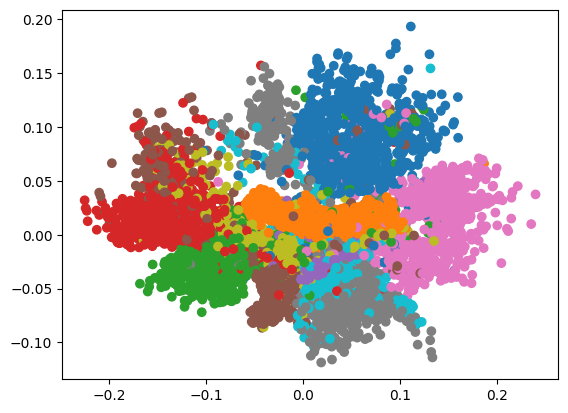

In [22]:
latents_combined_dc = torch.empty(0)
targets_combined_dc = torch.empty(0)
for latent, target in zip(latents_dc, targets_dc):
    latents_combined_dc = torch.cat((latents_combined_dc, latent), dim=0)
    targets_combined_dc = torch.cat((targets_combined_dc, target), dim=0)
    
projections_dc = PCA(n_components=2).fit_transform(latents_combined_dc)
plt.scatter(projections_dc[:,0], projections_dc[:,1], c=targets_combined_dc, cmap='tab10')

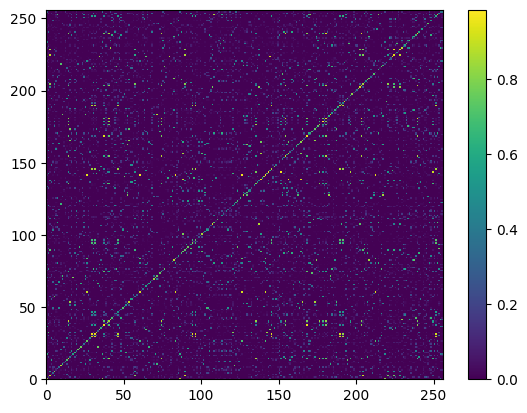

In [23]:
from torch.nn.functional import normalize

inputs_dc_normalized = normalize(inputs_dc[0], p=2, dim=1)
reconstructions_dc_normalized = normalize(reconstructions_dc[0], p=2, dim=1)

plt.pcolormesh(torch.mm(inputs_dc_normalized, reconstructions_dc_normalized.T))
plt.colorbar()

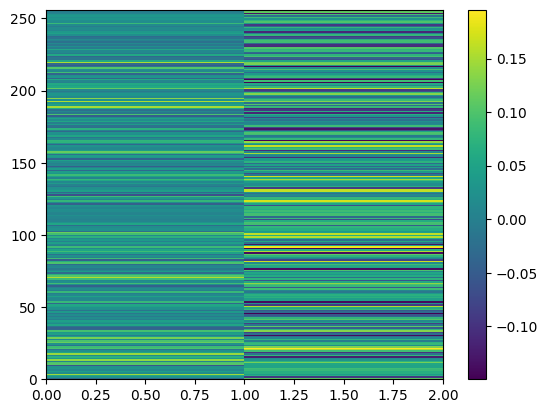

In [24]:
plt.pcolormesh(latents_dc[0])
plt.colorbar()

In [91]:
def standardize(input: torch.Tensor, dim: int = 1):
    return (input - input.mean(dim=1, keepdim=True))/input.std(dim=1, keepdim=True)

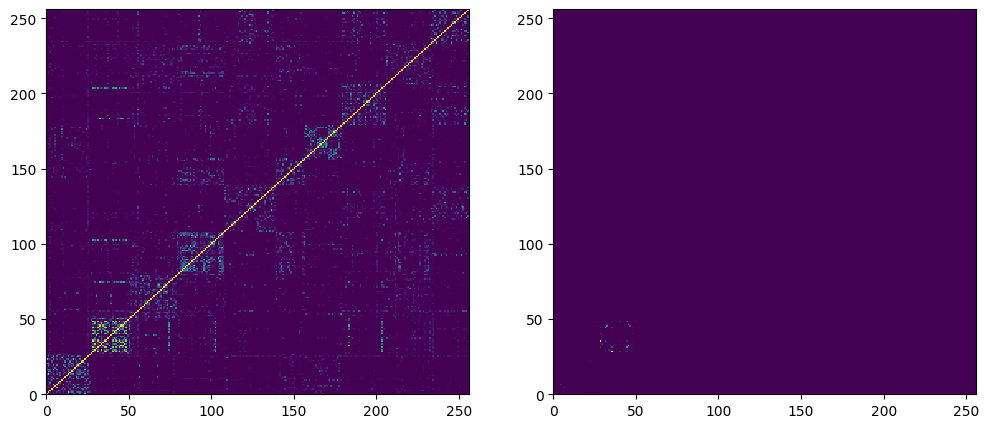

In [101]:
batch = 2

sorted_idx = torch.argsort(targets_dc[batch])
inputs_dc_sorted = inputs_dc[batch][sorted_idx]
inputs_dc_sorted_n = normalize(inputs_dc_sorted, p=2, dim=1)
inputs_dc_sorted_s = standardize(inputs_dc_sorted)

softmax = nn.Softmax(dim=1)
similarity = torch.mm(inputs_dc_sorted_n, inputs_dc_sorted_n.T)
attention = softmax(torch.mm(inputs_dc_sorted_s, inputs_dc_sorted_s.T)/(DC_OUT_DIM**0.5))

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].pcolormesh(similarity)
ax[1].pcolormesh(attention.fill_diagonal_(0))

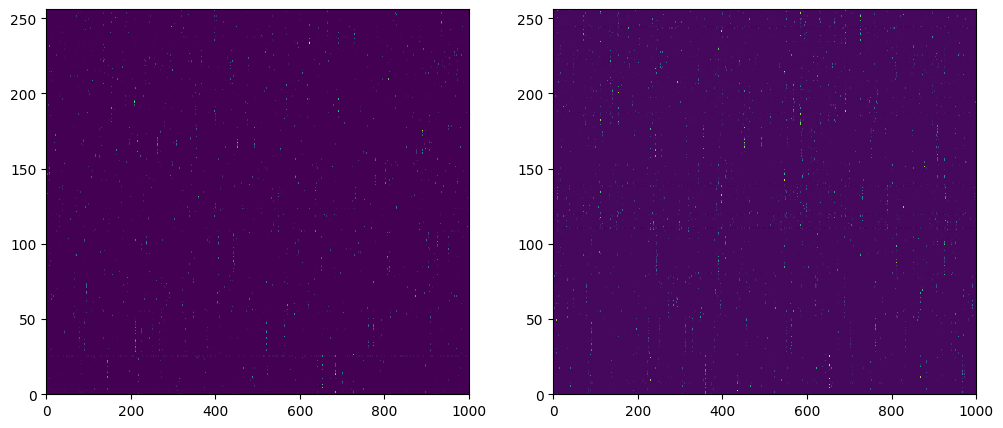

In [102]:
out = standardize(torch.mm(attention, inputs_dc_sorted))
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].pcolormesh(inputs_dc_sorted)
ax[1].pcolormesh(out)

In [23]:
import torch

x = torch.rand(1, 5)
(x > 0.5).sum(dim=1) == 

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [22]:
y = torch.empty(0)
len(y)

0